In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt
from datetime import date as d

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func
from sqlalchemy import create_engine, inspect

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# Declare a Base using `automap_base()`
Base = automap_base()

In [7]:
# Use the Base class to reflect the database tables
Base.prepare(engine, reflect=True)

In [8]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [9]:
# Initialize inspector to explore data
inspector = inspect(engine)

In [10]:
# Save references to each table
measurement = Base.classes.measurement
station = Base.classes.station

In [11]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [12]:
# Take a loot at the first row in dictionary form from a query
first_row = session.query(measurement).first()
first_row.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x116eab8d0>,
 'station': 'USC00519397',
 'tobs': 65.0,
 'prcp': 0.08,
 'date': '2010-01-01',
 'id': 1}

In [13]:
# Take a loot at the first row in dictionary form from a query
first_row = session.query(station).first()
first_row.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x116eb7490>,
 'station': 'USC00519397',
 'latitude': 21.2716,
 'elevation': 3.0,
 'name': 'WAIKIKI 717.2, HI US',
 'id': 1,
 'longitude': -157.8168}

In [14]:
last_row = (session
            .query(measurement)
            .order_by(measurement.id.desc())
            .first())

last_row.date

'2017-08-23'

In [15]:
# Query last 12 months of precipitation data
rows_12_months_before = (session
 .query(measurement)
 .filter(measurement.date > '2016-08-23')
 .order_by(measurement.date))

rows_12_months_before

In [16]:
lst_12_mont_prcp = []
for result in rows_12_months_before:
    if type(result.prcp) == float :
        lst_12_mont_prcp.append(result.prcp)

lst_12_mont_date = []
for result in rows_12_months_before:
    if type(result.prcp) == float:
        lst_12_mont_date.append(result.date)

In [17]:
# Save the query results as a Pandas DataFrame and set the index to the date column
df = pd.DataFrame(lst_12_mont_prcp, lst_12_mont_date)
df.head()
df = df.rename(columns=({0:'PRCP'}))
df

,PRCP
2016-08-24,0.08
2016-08-24,2.15
2016-08-24,2.28
2016-08-24,1.22
2016-08-24,2.15
...,...
2017-08-22,0.50
2017-08-23,0.00
2017-08-23,0.00
2017-08-23,0.08


In [18]:
# Reser index to push out date column
df
df1 = df.reset_index()
df1 = df.rename(columns=({'index':'Date'}))
df1

,PRCP
2016-08-24,0.08
2016-08-24,2.15
2016-08-24,2.28
2016-08-24,1.22
2016-08-24,2.15
...,...
2017-08-22,0.50
2017-08-23,0.00
2017-08-23,0.00
2017-08-23,0.08


In [19]:
# Set index to datetime type for graphing and rename PRCP
df1.index = pd.to_datetime(df1.index,format='%Y-%m-%d')
df1

,PRCP
2016-08-24,0.08
2016-08-24,2.15
2016-08-24,2.28
2016-08-24,1.22
2016-08-24,2.15
...,...
2017-08-22,0.50
2017-08-23,0.00
2017-08-23,0.00
2017-08-23,0.08


In [20]:
# Set DF to groupby aggregating mean
df1 = df1.groupby(pd.Grouper(freq='M')).mean()
df1.index

DatetimeIndex(['2016-08-31', '2016-09-30', '2016-10-31', '2016-11-30',
               '2016-12-31', '2017-01-31', '2017-02-28', '2017-03-31',
               '2017-04-30', '2017-05-31', '2017-06-30', '2017-07-31',
               '2017-08-31'],
              dtype='datetime64[ns]', freq='M')

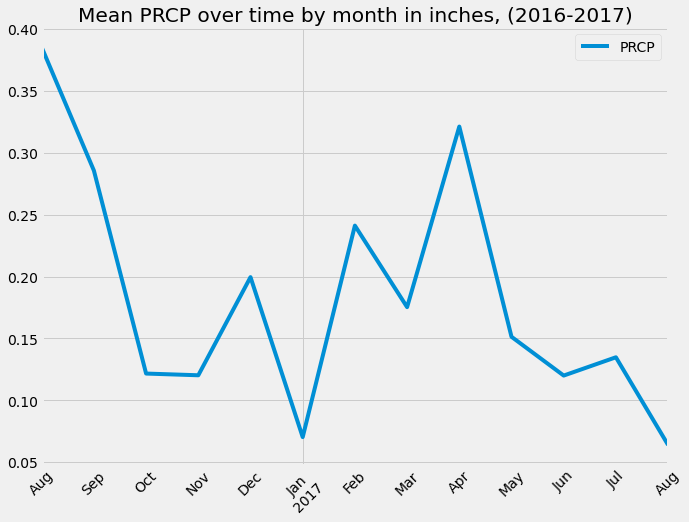

In [21]:
# Run Pandas plot on aggregated PRCP data.
df1.plot(figsize = (10,7.5), rot = 45, title = "Mean PRCP over time by month in inches, (2016-2017)")
plt.savefig('main_output/graph_line_prcp.png')

# Exploratory Climate Analysis

In [22]:
# Use Pandas to calcualte the summary statistics for the precipitation data
df.describe()

,PRCP
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [23]:
# Design a query to show how many stations are available in this dataset?
(session
 .query(station)
 .count())

9

In [24]:
# To discover the most active stations, since sations can 
# be considered a linking key between the two datasets
# I decided to use a session.query on measurements.

session.query(func.max(measurement.station)).first()

('USC00519523')

In [25]:
# This query returns all measurements taken grouped by station_id
# in descending order.
grouped_measurements = (session
 .query(measurement.station, func.count(measurement.station))
 .group_by(measurement.station)
 .order_by(func.count(measurement.station).desc())
 .all())

grouped_measurements

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [26]:
# What are the most active stations? (i.e. what stations have the most rows)?
max(grouped_measurements)

('USC00519523', 2669)

In [27]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
USC00519523 = (session
 .query(measurement)
 .filter(measurement.date > '2016-08-23', measurement.station == 'USC00519523'))

USC00519523.count()

# Create y values for graph of last 12 months
USC00519523_temps = []

for temp in USC00519523:
    if type(temp.tobs) == float:
        USC00519523_temps.append(temp.tobs)
        
USC00519523_temps
        
# Create x values (dates) for graph
USC00519523_dates = []

for date in USC00519523:
    if type(temp.date) == str:
        USC00519523_dates.append(temp.date)

USC00519523_temps
USC00519523_dates

df2 = pd.DataFrame(USC00519523_temps, USC00519523_dates, columns=({'tobs'}))
df2.index.name = "Dates"
df2

,tobs
Dates,
2017-08-23,79.0
2017-08-23,80.0
2017-08-23,84.0
2017-08-23,81.0
2017-08-23,80.0
...,...
2017-08-23,83.0
2017-08-23,85.0
2017-08-23,82.0


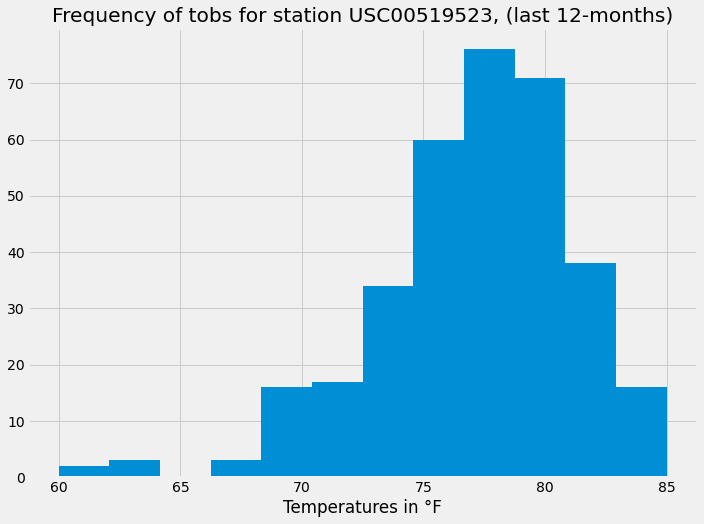

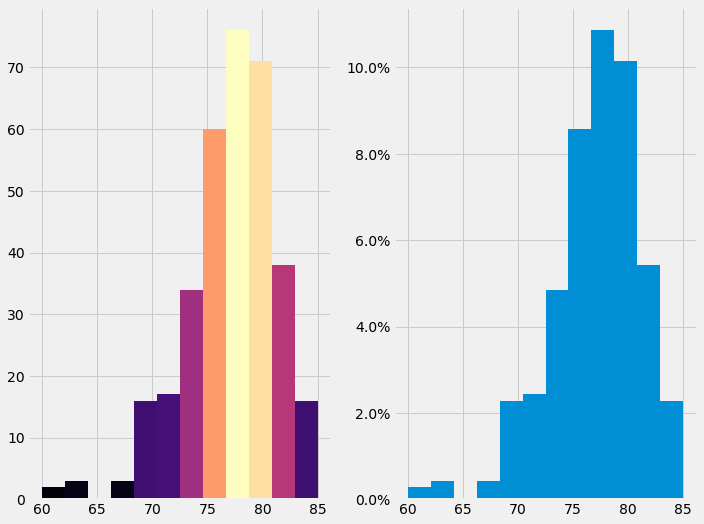

In [28]:
# Plot a histogram of frequencies of temperatures for
# last 12-months
from matplotlib import colors
from matplotlib.ticker import PercentFormatter

plt.figure(figsize=(10, 7.5), tight_layout=True) 
plt.hist(df2['tobs'], bins=12)
plt.title('Frequency of tobs for station USC00519523, (last 12-months)')
plt.xlabel('Temperatures in °F')

plt.savefig('main_output/graph_hist_top_12months.png')

# This is assigning the same funtion twice?
fig, axs = plt.subplots(1, 2, tight_layout=True, figsize=(10,7.5))

# N is the count in each bin, bins is the lower-limit of the bin
# N receives an array of count in each bin, bins recieve an array, 
# and pacthes receive a list of 12 patch objects
N, bins, patches = axs[0].hist(df2['tobs'], bins=12)

# We'll color code by height, but you could use any scalar
# Variable fracs is equal to the (array) number in each bin
# divided by the highest number in a bin (76)
# This produces an array of fractions of the max (i.e. 2/76)
fracs = N / N.max()

# we need to normalize the data to 0..1 for the full range of the colormap
# Calls the subfunction of colors, normalize, to set fract values
# for using colors (setting mins and maxs)
norm = colors.Normalize(fracs.min(), fracs.max())

# Now, we'll loop through our objects and set the color of each accordingly
# 
for thisfrac, thispatch in zip(fracs, patches):
    color = plt.cm.magma(norm(thisfrac))
    thispatch.set_facecolor(color)

# We can also normalize our inputs by the total number of counts
axs[1].hist(df2['tobs'], bins=12, density=True)

# Now we format the y-axis to display percentage
axs[1].yaxis.set_major_formatter(PercentFormatter(xmax=1))

plt.savefig('main_output/graph_hist_top_12months_magma.png')

## Bonus Challenge Assignment

In [29]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

NameError: name 'Measurement' is not defined

In [ ]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.


In [ ]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)


In [ ]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



In [ ]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

In [ ]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [ ]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [ ]:
# Plot the daily normals as an area plot with `stacked=False`
